In [68]:
import psycopg2
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from datetime import datetime

In [24]:
connection = psycopg2.connect(user="alexeykoshevoy", dbname='slovotvir_db')

In [25]:
# Create a cursor to perform database operations
cursor = connection.cursor()

In [38]:
# execute a statement
# get the structure of the table
cursor.execute("SELECT  words.id AS word_id, words.body AS word_body,"
               "translations.id AS translation_id,   translations.body" 
               "AS translation_body,   translations.rating," 
               "translations.created_at AS translation_created_at,"
               "words.translations_count FROM   words LEFT JOIN" 
               "translations ON words.id = translations.word_id ORDER BY"
               "words.id ASC, translations.created_at ASC;")

In [34]:
# retrieve the records from the database
records = cursor.fetchall()
# save as .csv file
import csv
with open('data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['word_id', 'word_body', 'translation_id', 'translation_body', 'rating', 'translation_created_at', 'translations_count'])
    for row in records:
        writer.writerow(row)

# close the communication with the PostgreSQL
cursor.close()
connection.close()


In [74]:
df = pd.read_csv('data.csv')

In [149]:
# normalize rating per word

df['rating'] = df['rating'].fillna(0)
df['rating'] = df['rating'].astype(int)
# only keep rows where rating is not 0
df = df[df['rating'] != 0]
# subtract mean and divide by std per word
df['rating_n'] = df.groupby('word_id')['rating'].transform(lambda x: (x - x.mean()) / x.std())

In [150]:
# only keep words where there is only one word in translation body
# df = df[df['translation_body'].str.split().str.len() == 1]
# count the number of letters in the translation
df['translation_length'] = df['translation_body'].str.len()

In [151]:
# dropna from rating_n
df = df.dropna(subset=['rating_n'])

In [152]:
df['translation_created_at'] = pd.to_datetime(df['translation_created_at'])
df['translation_age'] = datetime.now() - df['translation_created_at']
df['translation_age'] = df['translation_age'].dt.days


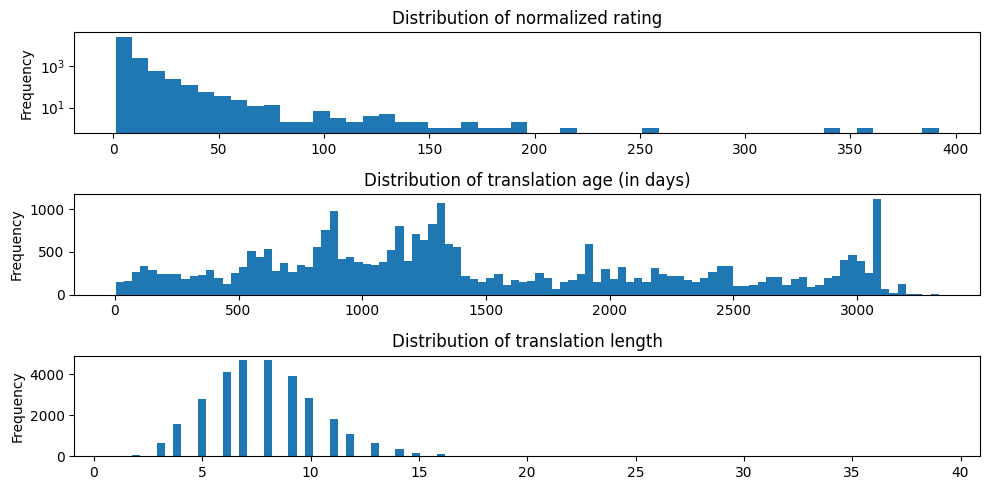

In [153]:
# plot the distribution of number of likes, age and length of translation on the same plot with 3 subplots organizer in 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 5))
# df['rating'].plot(kind='hist', ax=axes[0], bins=50, title='Distribution of normalized rating')
# group rating by 20 likes (0-20, 20-40, 40-60, etc.)
df['rating'].plot(kind='hist', ax=axes[0], bins=50, title='Distribution of normalized rating', logy=True)
df['translation_age'].plot(kind='hist', ax=axes[1], bins=100, title='Distribution of translation age (in days)')
df['translation_length'].plot(kind='hist', ax=axes[2], bins=100, title='Distribution of translation length')
plt.tight_layout()
plt.show()

In [154]:
# count the number of words in word_body
df['n_words_word'] = df['word_body'].str.split().apply(len)
# count the number of words in translation_body
df['n_words_translation'] = df['translation_body'].str.split().apply(len)

In [157]:
df.columns

Index(['word_id', 'word_body', 'translation_id', 'translation_body', 'rating',
       'translation_created_at', 'translations_count', 'rating_n',
       'translation_length', 'translation_age', 'rating_bin', 'n_words_word',
       'n_words_translation'],
      dtype='object')

In [158]:
df.shape

(29573, 13)

In [159]:
df['word_body'].unique().shape

(5626,)